# Part 1

In [136]:
with open('climate_vocab.txt') as f:
    climate_vocab = f.read().lower().splitlines()
    
print(climate_vocab)

['greenhousegas', 'global', 'carbon', 'emissions', 'warming', 'fossil', 'fuels', 'sea-level', 'sea', 'temperature', 'renewable', 'unfcc', 'cop', 'paris', 'intendednationallydeterminedcontribution', 'ipcc', 'intergovernmental', 'ppm', 'methane', 'pre-industrial', 'mitigation', 'fracking', 'climatechange', 'weather', 'heat', 'atmosphere', 'earth', 'preventativemeasures', 'preventative', 'carbon', 'ecosystem', 'fuel', 'gas', 'oil']


In [3]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} datetime

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - datetime

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [4]:
import pandas as pd
import datetime as dt
import dask
import glob
import json
import numpy as np
from edgar import Company, TXTML
from edgar import Edgar
import nltk
from nltk.corpus import stopwords
from textblob import Word
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

### Retrieving data

In [5]:
def get_edgar(ll, n):
    filinglist = []
    for el in ll:
        company = Company(el[0], el[1])
        tree = company.get_all_filings(filing_type = "10-K")
        docs = Company.get_documents(tree, no_of_documents=n, as_documents=True)
        texts = Company.get_documents(tree, no_of_documents=n, as_documents=False)
        if n<2:
            docs=[docs]
            texts=[texts]
        for i in range(n):
            date = docs[i].content['Filing Date']
            dateStr = str(date)
            year = date[:4]
            text = TXTML.parse_full_10K(texts[i])
            filinglist.append([el[0],el[1],date,year, text])
    df = pd.DataFrame(filinglist, columns=['Company','CIK','Filing_Date','Year','TEXT'])
    return df

### Generating dataframes

In [110]:
#tech companies
tech_companies = [
    ['Alphabet Inc.','0001652044'],
    ['Apple Inc.', '0000320193'],
    ['Microsoft Corp','0000789019'],
    ['IBM Corp', '0000051143'],
    ['INTEL CORP', "50863"]
]

tech_companiesDF = get_edgar(tech_companies,5)

#financials companies
fin_companies = [
    ['Berkshire Hathaway','1067983'],
    ['JPMORGAN CHASE & CO', '00000019617'],
    ['Fannie Mae','310522'],
    ['METLIFE INC', '1099219'],
    ['CITIGROUP INC', '0000831001']
]

fin_companiesDF = get_edgar(fin_companies,5)

#energy companies
energy_companies = [
    ['EXXON MOBIL CORP','0000034088'],
    ['CHEVRON CORP', '0000093410'],
    ['MARATHON OIL CORP','0000101778'],
    ['Phillips 66', '0001534701'],
    ['Energy Transfer LP', '0001276187']
]

energy_companiesDF = get_edgar(energy_companies,5)
energy_companiesDF

,Company,CIK,Filing_Date,Year,TEXT
0,EXXON MOBIL CORP,0000034088,2020-02-26,2020,\n\n\n\n\n\n\n\n\n\n 0.086252036-04-012021-08-...
1,EXXON MOBIL CORP,0000034088,2019-02-27,2019,\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n...
2,EXXON MOBIL CORP,0000034088,2018-02-28,2018,\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n...
3,EXXON MOBIL CORP,0000034088,2017-02-22,2017,\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n...
4,EXXON MOBIL CORP,0000034088,2016-02-24,2016,\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n...
5,CHEVRON CORP,0000093410,2020-02-21,2020,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...
6,CHEVRON CORP,0000093410,2019-02-22,2019,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...
7,CHEVRON CORP,0000093410,2018-02-22,2018,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...
8,CHEVRON CORP,0000093410,2017-02-23,2017,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...
9,CHEVRON CORP,0000093410,2016-02-25,2016,\n\n\n\t\n\t\t\n\t\t\n\t\t10-K\n\t\n\t\n UNITE...


### Clean text function

In [111]:
#stopwords
stop = set(stopwords.words('english'))

def clean_text(DF): 
    #lowercase
    DF['TEXT'] = DF['TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

    #remove punctuation
    DF['TEXT'] = DF['TEXT'].str.replace('[^\w\s]','').replace('/_/g', "")

    #remove stopwords
    DF['TEXT'] = DF['TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    #remove numbers
    DF['TEXT'] = DF['TEXT'].str.replace('\d+', '')

    #remove non-english words
    nltk.download('words')
    words = set(nltk.corpus.words.words())

    DF['TEXT'] = DF['TEXT'].apply(lambda x: " ".join(x for x in str(x).split() if x.lower() in words or not x.isalpha()))
    
    return DF

### Cleaning the dataframes

In [112]:
#tech
tech_companiesDF = clean_text(tech_companiesDF)

#financials
fin_companiesDF = clean_text(fin_companiesDF)

#energy
energy_companiesDF = clean_text(energy_companiesDF)

[nltk_data] Downloading package words to /users/mtedrow/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /users/mtedrow/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /users/mtedrow/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Remove frequent words function

In [113]:
#remove frequent words
def remove_freq(DF):
    freq = pd.Series(' '.join(DF['TEXT']).split()).value_counts()[:10]
    freq

    freq = list(freq.index)
    DF['TEXT'] = DF['TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    DF['TEXT'].head()
    return DF

### Removing frequent words

In [114]:
#tech
remove_freq(tech_companiesDF)

#energy
remove_freq(energy_companiesDF)

#financials
remove_freq(fin_companiesDF)

,Company,CIK,Filing_Date,Year,TEXT
0,Berkshire Hathaway,1067983,2020-02-24,2020,brkak_htm false large accelerated filer united...
1,Berkshire Hathaway,1067983,2019-02-25,2019,k table contents united exchange commission fo...
2,Berkshire Hathaway,1067983,2018-02-26,2018,k table contents united exchange commission fo...
3,Berkshire Hathaway,1067983,2017-02-27,2017,form k table contents united exchange commissi...
4,Berkshire Hathaway,1067983,2016-02-29,2016,form k table contents united exchange commissi...
5,JPMORGAN CHASE & CO,00000019617,2020-02-25,2020,document jpmloan_payment jpmloan_segment unite...
6,JPMORGAN CHASE & CO,00000019617,2019-02-26,2019,document accelerated chase jpmloan_payment jpm...
7,JPMORGAN CHASE & CO,00000019617,2018-02-27,2018,document united exchange form report pursuant ...
8,JPMORGAN CHASE & CO,00000019617,2017-02-28,2017,document united exchange form report pursuant ...
9,JPMORGAN CHASE & CO,00000019617,2016-02-23,2016,k united exchange form report pursuant section...


### Cleaned data frames

In [115]:
tech_companies = tech_companiesDF[['Company', 'CIK', 'Filing_Date', 'Year','TEXT']].sort_values(by='Filing_Date', ascending=True)

energy_companies = energy_companiesDF[['Company', 'CIK', 'Filing_Date', 'Year','TEXT']].sort_values(by='Filing_Date', ascending=True)

fin_companies = fin_companiesDF[['Company', 'CIK', 'Filing_Date', 'Year','TEXT']].sort_values(by='Filing_Date', ascending=True)

### Frequency of special words

In [137]:
#Create frequency of special words found in tech companies
techfreqList = []
for text in tech_companiesDF['TEXT']:
    wordlist = text.split()
    clean_words = []
    for word in wordlist:
        if word in climate_vocab:
            clean_words.append(Word(re.sub("[^a-zA-Z]+", "", word)).lemmatize())
            
    count = Counter(clean_words)
    total = 0
    for w, frequency in count.items():
        total = total + frequency
    techfreqList.append(total)
    
#Create frequency of special words found in energy companies
energyfreqList = []
for text in energy_companiesDF['TEXT']:
    wordlist = text.split()
    clean_words = []
    for word in wordlist:
        if word in climate_vocab:
            clean_words.append(Word(re.sub("[^a-zA-Z]+", "", word)).lemmatize())
            
    count = Counter(clean_words)
    total = 0
    for w, frequency in count.items():
        total = total + frequency
    energyfreqList.append(total)
    
#Create frequency of special words found in financial companies
finfreqList = []
for text in fin_companiesDF['TEXT']:
    wordlist = text.split()
    clean_words = []
    for word in wordlist:
        if word in climate_vocab:
            clean_words.append(Word(re.sub("[^a-zA-Z]+", "", word)).lemmatize())
            
    count = Counter(clean_words)
    total = 0
    for w, frequency in count.items():
        total = total + frequency
    finfreqList.append(total)
     

In [138]:
tech_companiesDF['Frequency'] = techfreqList

energy_companiesDF['Frequency'] = energyfreqList

fin_companiesDF['Frequency'] = finfreqList
fin_companiesDF

,Company,CIK,Filing_Date,Year,TEXT,Frequency
24,CITIGROUP INC,0000831001,2016-02-26,2016,k united exchange form k annual report pursuan...,127
19,METLIFE INC,1099219,2016-02-25,2016,k united exchange __________________________fo...,127
4,Berkshire Hathaway,1067983,2016-02-29,2016,form k table contents united exchange commissi...,171
14,Fannie Mae,310522,2016-02-19,2016,k united exchange form report pursuant section...,43
9,JPMORGAN CHASE & CO,00000019617,2016-02-23,2016,k united exchange form report pursuant section...,129
3,Berkshire Hathaway,1067983,2017-02-27,2017,form k table contents united exchange commissi...,180
18,METLIFE INC,1099219,2017-03-01,2017,document united exchange _____________________...,131
8,JPMORGAN CHASE & CO,00000019617,2017-02-28,2017,document united exchange form report pursuant ...,140
13,Fannie Mae,310522,2017-02-17,2017,document united exchange form report pursuant ...,45
23,CITIGROUP INC,0000831001,2017-02-24,2017,document united exchange form k annual report ...,112


### Graphing tech companies

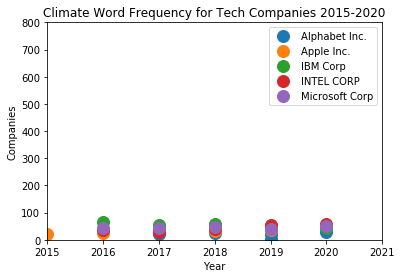

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Generate Data
tech_companiesDF['Year'] = tech_companiesDF['Year'].astype(int)
tech_companiesDF.sort_values(by='Year', inplace=True, ascending=True)
df = pd.DataFrame(dict(x= tech_companiesDF['Year'], y = tech_companiesDF['Frequency'], label = tech_companiesDF['Company']))
groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax = plt.gca()
ax.set_xlim([2015,2021])
ax.set_ylim([0,800])
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.title('Climate Word Frequency for Tech Companies 2015-2020')
plt.xlabel('Year')
plt.ylabel('Companies')

plt.show()

### Graphing energy companies

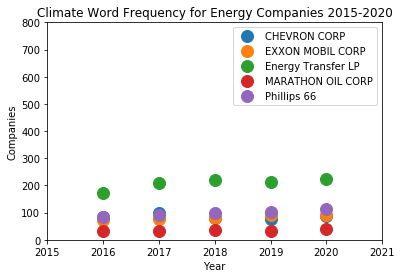

In [140]:
# Generate Data
energy_companiesDF['Year'] = energy_companiesDF['Year'].astype(int)
energy_companiesDF.sort_values(by='Year', inplace=True, ascending=True)
df = pd.DataFrame(dict(x= energy_companiesDF['Year'], y = energy_companiesDF['Frequency'], label = energy_companiesDF['Company']))
groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax = plt.gca()
ax.set_xlim([2015,2021])
ax.set_ylim([0,800])
ax.margins(0)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.title('Climate Word Frequency for Energy Companies 2015-2020')
plt.xlabel('Year')
plt.ylabel('Companies')

plt.show()

### Graphing financial companies

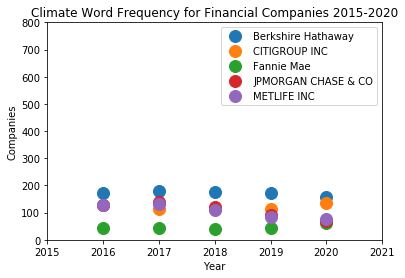

In [141]:
# Generate Data
fin_companiesDF['Year'] = fin_companiesDF['Year'].astype(int)
fin_companiesDF.sort_values(by='Year', inplace=True, ascending=True)
df = pd.DataFrame(dict(x= fin_companiesDF['Year'], y = fin_companiesDF['Frequency'], label = fin_companiesDF['Company']))
groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax = plt.gca()
ax.set_xlim([2015,2021])
ax.set_ylim([0,800])
ax.margins(0)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.title('Climate Word Frequency for Financial Companies 2015-2020')
plt.xlabel('Year')
plt.ylabel('Companies')

plt.show()

# Part 2: OED Changes

In [142]:
with open('OEDlist.txt') as f:
    OEDclimate_vocab = f.read().lower().splitlines()

#Create frequency of special words found in tech companies
techfreqList = []
for text in tech_companiesDF['TEXT']:
    wordlist = text.split()
    clean_words = []
    for word in wordlist:
        if word in OEDclimate_vocab:
            clean_words.append(Word(re.sub("[^a-zA-Z]+", "", word)).lemmatize())
            
    count = Counter(clean_words)
    total = 0
    for w, frequency in count.items():
        total = total + frequency
    techfreqList.append(total)
    
#Create frequency of special words found in energy companies
energyfreqList = []
for text in energy_companiesDF['TEXT']:
    wordlist = text.split()
    clean_words = []
    for word in wordlist:
        if word in OEDclimate_vocab:
            clean_words.append(Word(re.sub("[^a-zA-Z]+", "", word)).lemmatize())
            
    count = Counter(clean_words)
    total = 0
    for w, frequency in count.items():
        total = total + frequency
    energyfreqList.append(total)
    
#Create frequency of special words found in financial companies
finfreqList = []
for text in fin_companiesDF['TEXT']:
    wordlist = text.split()
    clean_words = []
    for word in wordlist:
        if word in OEDclimate_vocab:
            clean_words.append(Word(re.sub("[^a-zA-Z]+", "", word)).lemmatize())
            
    count = Counter(clean_words)
    total = 0
    for w, frequency in count.items():
        total = total + frequency
    finfreqList.append(total)
    

tech_companiesDF['Frequency'] = techfreqList
energy_companiesDF['Frequency'] = energyfreqList
fin_companiesDF['Frequency'] = finfreqList

fin_companiesDF

,Company,CIK,Filing_Date,Year,TEXT,Frequency
24,CITIGROUP INC,0000831001,2016-02-26,2016,k united exchange form k annual report pursuan...,196
19,METLIFE INC,1099219,2016-02-25,2016,k united exchange __________________________fo...,663
4,Berkshire Hathaway,1067983,2016-02-29,2016,form k table contents united exchange commissi...,160
14,Fannie Mae,310522,2016-02-19,2016,k united exchange form report pursuant section...,148
9,JPMORGAN CHASE & CO,00000019617,2016-02-23,2016,k united exchange form report pursuant section...,139
3,Berkshire Hathaway,1067983,2017-02-27,2017,form k table contents united exchange commissi...,162
18,METLIFE INC,1099219,2017-03-01,2017,document united exchange _____________________...,722
8,JPMORGAN CHASE & CO,00000019617,2017-02-28,2017,document united exchange form report pursuant ...,126
13,Fannie Mae,310522,2017-02-17,2017,document united exchange form report pursuant ...,117
23,CITIGROUP INC,0000831001,2017-02-24,2017,document united exchange form k annual report ...,183


### Graphing changes

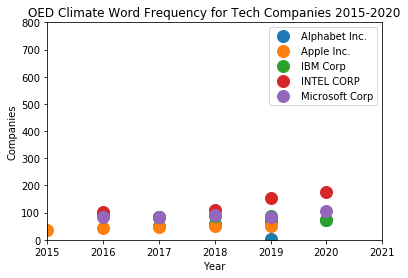

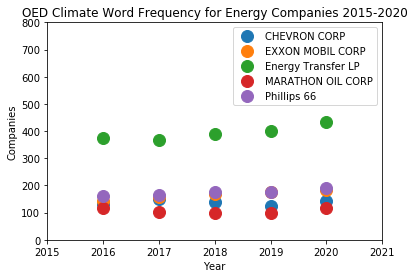

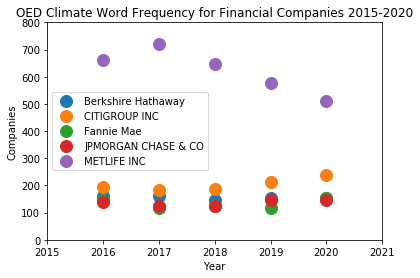

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# TECH
tech_companiesDF['Year'] = tech_companiesDF['Year'].astype(int)
tech_companiesDF.sort_values(by='Year', inplace=True, ascending=True)
df = pd.DataFrame(dict(x= tech_companiesDF['Year'], y = tech_companiesDF['Frequency'], label = tech_companiesDF['Company']))
groups = df.groupby('label')

fig, ax = plt.subplots()
ax = plt.gca()
ax.set_xlim([2015,2021])
ax.set_ylim([0,800])
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.title('OED Climate Word Frequency for Tech Companies 2015-2020')
plt.xlabel('Year')
plt.ylabel('Companies')

plt.show()

# ENERGY
energy_companiesDF['Year'] = energy_companiesDF['Year'].astype(int)
energy_companiesDF.sort_values(by='Year', inplace=True, ascending=True)
df = pd.DataFrame(dict(x= energy_companiesDF['Year'], y = energy_companiesDF['Frequency'], label = energy_companiesDF['Company']))
groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax = plt.gca()
ax.set_xlim([2015,2021])
ax.set_ylim([0,800])
ax.margins(0)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.title('OED Climate Word Frequency for Energy Companies 2015-2020')
plt.xlabel('Year')
plt.ylabel('Companies')

plt.show()

# FINANCIALS
fin_companiesDF['Year'] = fin_companiesDF['Year'].astype(int)
fin_companiesDF.sort_values(by='Year', inplace=True, ascending=True)
df = pd.DataFrame(dict(x= fin_companiesDF['Year'], y = fin_companiesDF['Frequency'], label = fin_companiesDF['Company']))
groups = df.groupby('label')

fig, ax = plt.subplots()
ax = plt.gca()
ax.set_xlim([2015,2021])
ax.set_ylim([0,800])
ax.margins(0)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.title('OED Climate Word Frequency for Financial Companies 2015-2020')
plt.xlabel('Year')
plt.ylabel('Companies')

plt.show()